# Hand Gesture Classification Using MediaPipe & HaGRID


## Project Overview

This project focuses on the classification of hand gestures using landmark data generated by **MediaPipe** from the **HaGRID (Hand Gesture Recognition Image Dataset)**. By utilizing the spatial coordinates of hand keypoints, we aim to train a machine learning model capable of accurately identifying various gestures.

## Import Required Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Exploration

In [2]:
df = pd.read_csv("data\hand_landmarks_data.csv")
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [4]:
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

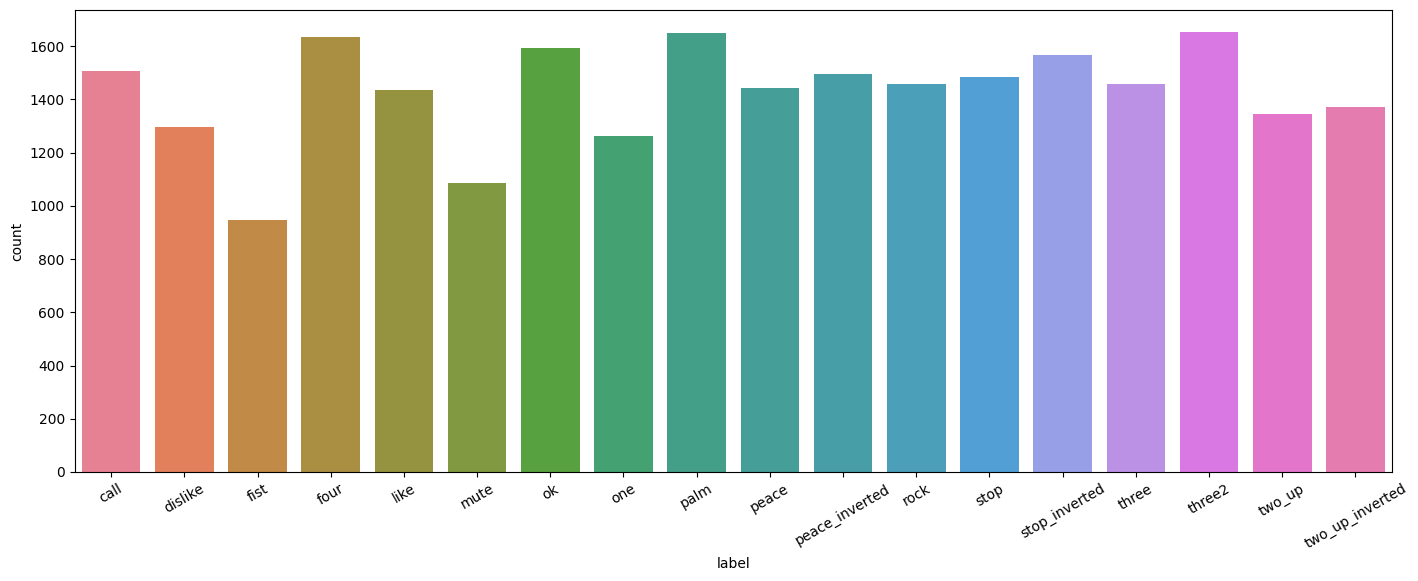

In [5]:
plt.figure(figsize=(17,6))
sns.countplot(data=df, x='label', hue='label')
plt.xticks(rotation=30)
plt.show()

So far we don't have any missing values or inconsistency in data types, our data contains 25675 rows and the data is quite unbalanced (we have shortage in fist & mute labels especially).

## Data Visualization

In [6]:
def plot_hand_landmarks(sample, ax=None):
    """
    Plot hand landmarks for a single sample.
    
    Parameters:
    -----------
    sample : pd.Series or dict
        A row from the dataframe containing x, y, z coordinates for 21 landmarks
    ax : matplotlib axis, optional
        Axis to plot on. If None, creates a new figure
    
    Returns:
    --------
    ax : matplotlib axis
        The axis with the plotted hand landmarks
    """
    # Extract x, y coordinates for all 21 landmarks
    x_coords = [sample[f'x{i}'] for i in range(1, 22)]
    y_coords = [sample[f'y{i}'] for i in range(1, 22)]
    
    # Create figure if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # MediaPipe hand landmark connections
    # Each tuple represents a connection between two landmark indices
    connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20),
        # Palm
        (5, 9), (9, 13), (13, 17)
    ]
    
    # Plot connections (lines between landmarks)
    for connection in connections:
        start_idx, end_idx = connection
        ax.plot([x_coords[start_idx], x_coords[end_idx]], 
                [y_coords[start_idx], y_coords[end_idx]], 
                'b-', linewidth=2, alpha=0.6)
    
    # Plot landmarks (points)
    ax.scatter(x_coords, y_coords, c='red', s=50, zorder=3)
    
    # Add landmark numbers
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        ax.annotate(str(i), (x, y), fontsize=8, ha='center', 
                   bbox=dict(boxstyle='circle,pad=0.1', facecolor='yellow', alpha=0.5))
    
    # Invert y-axis (image coordinates start from top-left)
    ax.invert_yaxis()
    
    # Set labels and title
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title(f'Hand Gesture: {sample["label"]}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    return ax

In [7]:
def plot_multiple_gestures(df, n_samples=6, random_state=42):
    """
    Plot multiple hand gesture samples for visual inspection.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing hand landmark data
    n_samples : int
        Number of samples to plot (default: 6)
    random_state : int
        Random seed for reproducibility
    """
    # Sample random gestures
    samples = df.sample(n=n_samples, random_state=random_state)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    # Plot each sample
    for idx, (_, sample) in enumerate(samples.iterrows()):
        plot_hand_landmarks(sample, ax=axes[idx])
    
    # Hide extra subplots if any
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_gestures_by_label(df, labels=None, samples_per_label=3, random_state=42):
    """
    Plot hand gesture samples grouped by label for comparison.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing hand landmark data
    labels : list, optional
        List of gesture labels to plot. If None, plots all unique labels
    samples_per_label : int
        Number of samples to show per label (default: 3)
    random_state : int
        Random seed for reproducibility
    """
    # Get labels to plot
    if labels is None:
        labels = df['label'].unique()[:5]  # Limit to 5 labels for readability
    
    n_labels = len(labels)
    
    # Create subplots
    fig, axes = plt.subplots(n_labels, samples_per_label, 
                             figsize=(5 * samples_per_label, 5 * n_labels))
    
    # Handle single row/column case
    if n_labels == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_label == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot samples for each label
    for row_idx, label in enumerate(labels):
        # Get samples for this label
        label_samples = df[df['label'] == label].sample(
            n=min(samples_per_label, len(df[df['label'] == label])), 
            random_state=random_state
        )
        
        for col_idx, (_, sample) in enumerate(label_samples.iterrows()):
            if col_idx < samples_per_label:
                plot_hand_landmarks(sample, ax=axes[row_idx, col_idx])
    
    plt.suptitle('Hand Gestures Grouped by Label', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

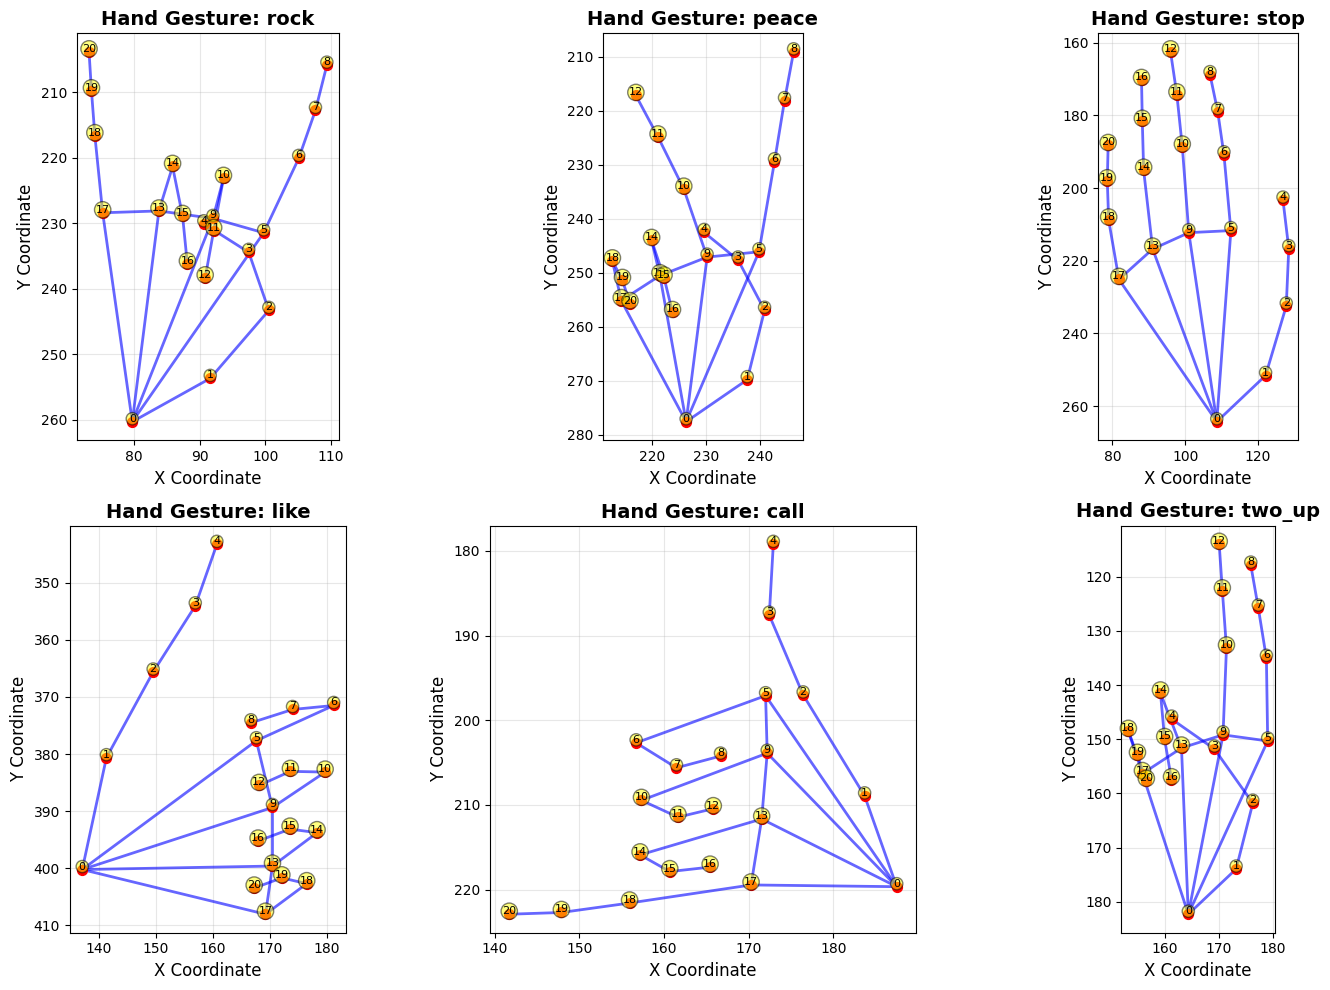

In [9]:
plot_multiple_gestures(df, n_samples=6)

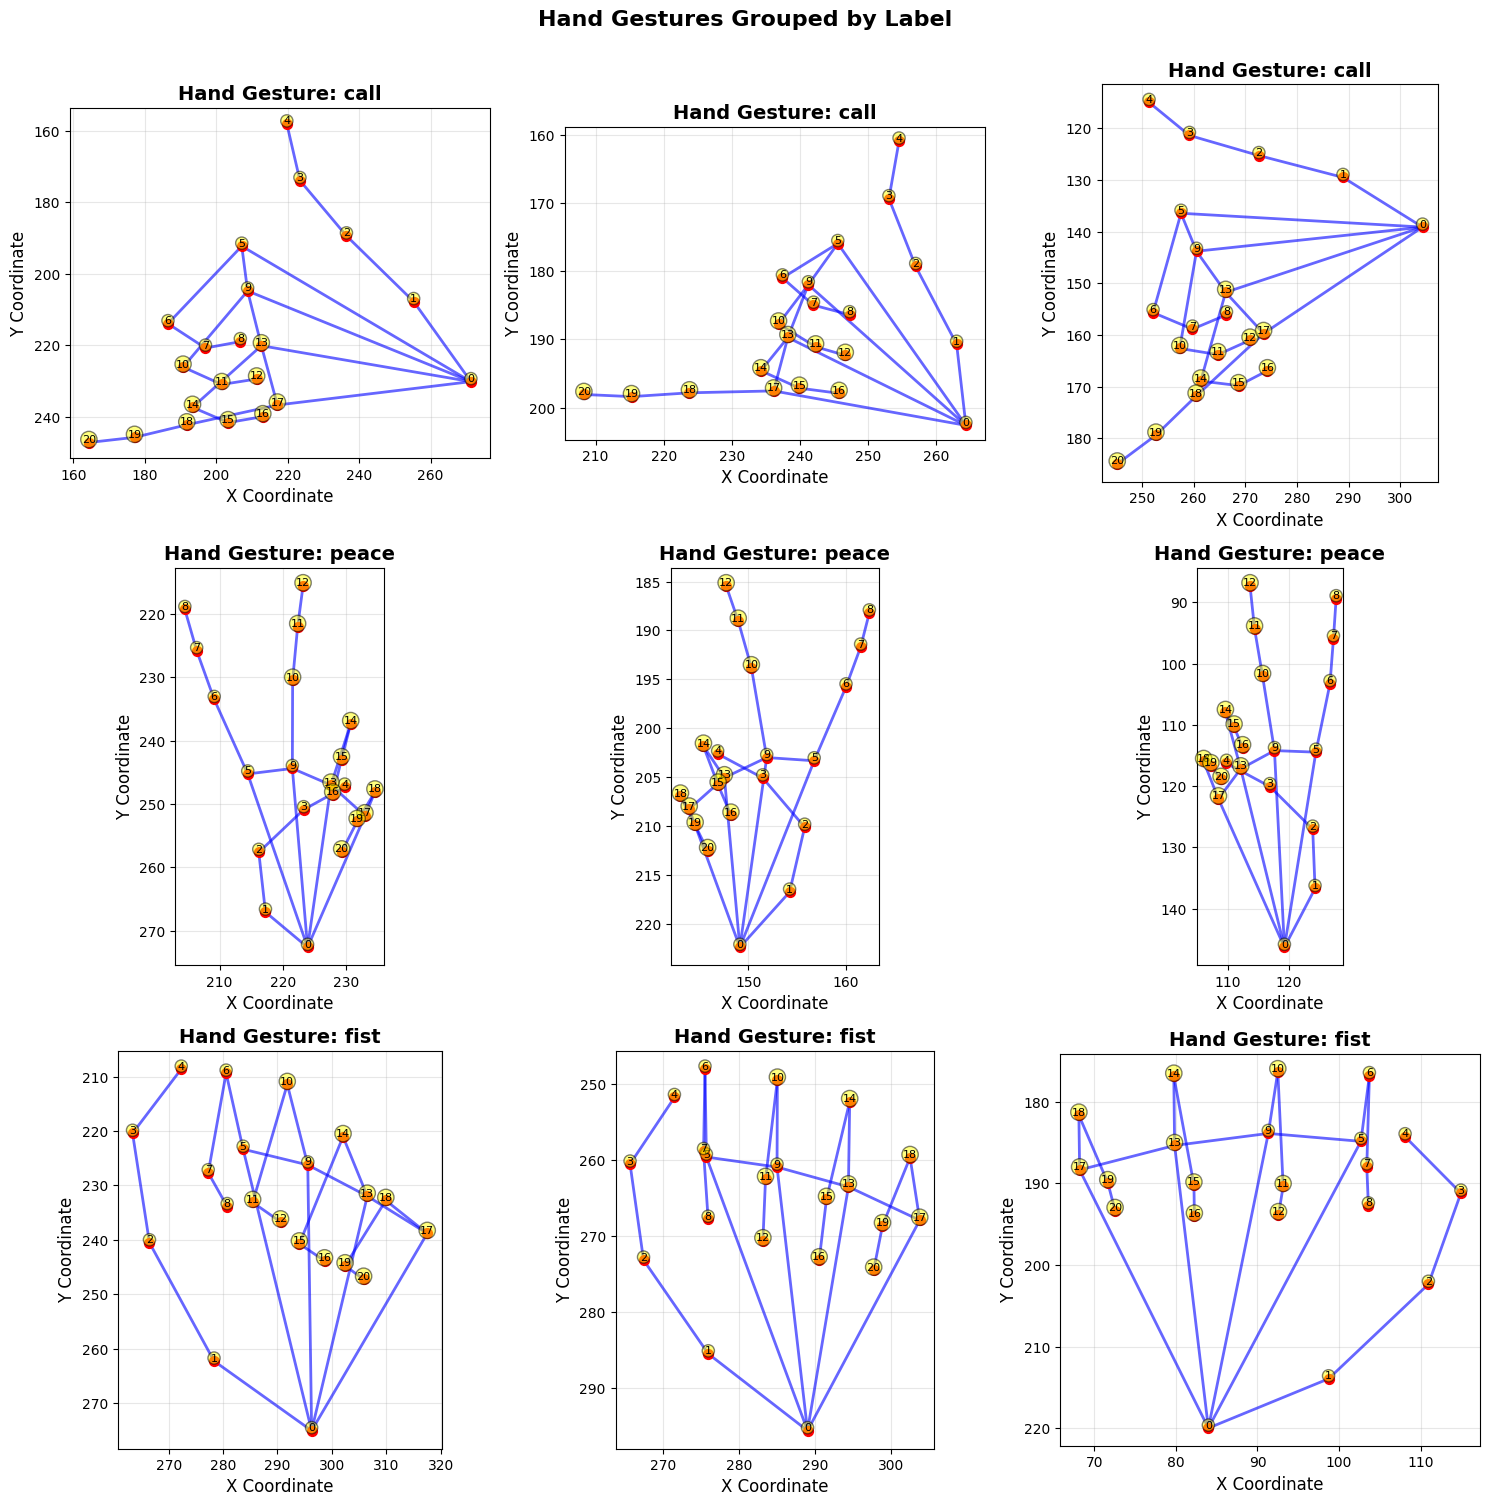

In [10]:
plot_gestures_by_label(df, labels=['call', 'peace', 'fist'], samples_per_label=3)